In [19]:
import torch
from torchvision import models
from torchvision import datasets, transforms
from datasets import Split_Dataset
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Subset
import numpy as np
import torch.nn.functional as F


normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

test_dataset = datasets.ImageFolder('/gpfs/u/locker/200/CADS/datasets/ImageNet/val', transform=val_transforms)

val_dataset = Split_Dataset('/gpfs/u/locker/200/CADS/datasets/ImageNet',  \
                    f'./calib_splits/am_imagenet_5percent_val.txt',
                    transform=val_transforms)

test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=256, shuffle=False,
            num_workers=20, pin_memory=True,
        )
val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=256, shuffle=False,
            num_workers=20, pin_memory=True,
        )

In [20]:
# model1 = models.resnet50().cuda()
# model2 = models.resnet50().cuda()
# model3 = models.resnet50().cuda()

# sd = torch.load("./dist_models/ft95perc_baseR_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
# ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
# model1.load_state_dict(ckpt)
# model1.eval()

# sd = torch.load("./dist_models/ft95perc_eqR_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
# ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
# model2.load_state_dict(ckpt)
# model2.eval()

# sd = torch.load("./dist_models/ft95perc_inv_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
# ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
# model3.load_state_dict(ckpt)
# model3.eval()

# gate = models.resnet18(num_classes=3).cuda()

In [21]:
# BEI
def load_3_models(ensem='BEI'):
    model1 = models.resnet50().cuda()
    model2 = models.resnet50().cuda()
    model3 = models.resnet50().cuda()
    if ensem == 'BEI':

        sd = torch.load("./dist_models/ft_baseR_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
        ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
        model1.load_state_dict(ckpt)
        
        sd = torch.load("./dist_models/ft_eqR_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
        ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
        model2.load_state_dict(ckpt)
        
        sd = torch.load("./dist_models/ft_inv_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
        ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
        model3.load_state_dict(ckpt)
        print("loaded BEI")
        
    elif ensem == 'EEE':
        sd = torch.load("./dist_models/ft_eqR_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
        ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
        model1.load_state_dict(ckpt)
        
        sd = torch.load("./dist_models/ft_eq69_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
        ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
        model2.load_state_dict(ckpt)
        
        sd = torch.load("./dist_models/ft_eq42_cos_lr0.003_bs256/checkpoint_best.pth", map_location="cpu")
        ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
        model3.load_state_dict(ckpt)
        print("loaded EEE")
        
    model1.eval()
    model2.eval()
    model3.eval()
    return model1, model2, model3

def load_1_model(ckpt_path, full_path=False):
    model1 = models.resnet50().cuda()
    if not full_path:
        sd = torch.load(f"./dist_models/{ckpt_path}/checkpoint_best.pth", map_location="cpu")
    else:
        sd = torch.load(ckpt_path, map_location="cpu")
    ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
    model1.load_state_dict(ckpt)
    print(f"loaded {ckpt_path}")
    model1.eval()
    return model1

def load_1_ts_model(ckpt_path, full_path=True):
    model1 = models.resnet50().cuda()
    model1.temp = torch.nn.Parameter(torch.ones(1) * 1.5)
    if not full_path:
        sd = torch.load(f"./dist_models/{ckpt_path}/checkpoint_best.pth", map_location="cpu")
    else:
        sd = torch.load(ckpt_path, map_location="cpu")
    ckpt = {k.replace("members.0.",""):v for k,v in sd['model'].items()}
    model1.load_state_dict(ckpt)
    print(f"loaded {ckpt_path}")
    model1.eval()
    return model1



In [22]:
import torch.nn.functional as F

class JSD(torch.nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = torch.nn.KLDivLoss(reduction='sum', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p = F.log_softmax(p, dim=-1)
        q = F.log_softmax(q, dim=-1)
        
        p, q = p.view(-1, p.size(-1)), q.view(-1, q.size(-1))
        m = (0.5 * (p + q)).log()
        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))

class KLD(torch.nn.Module):
    def __init__(self):
        super(KLD, self).__init__()
        self.kl = torch.nn.KLDivLoss(reduction='sum', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p = F.log_softmax(p, dim=-1)
        q = F.log_softmax(q, dim=-1)
        return self.kl(p,q)

kl_div = KLD()
js_div = JSD()


In [23]:
class _ECELoss(torch.nn.Module):

    def __init__(self, n_bins=20):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, softmaxes, labels):
#         softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=softmaxes.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

nll_criterion = torch.nn.CrossEntropyLoss().cuda()
ece_criterion = _ECELoss().cuda()

In [24]:
# ensem = 'EEE'

# model1, model2, model3 = load_3_models(ensem=ensem)
# def compute_pair_consensus(pair_preds):
#     agree = (pair_preds[0] == pair_preds[1])
#     agree_correct = agree & (pair_preds[0] == target)
#     agree_wrong = agree & (pair_preds[0] != target)
#     disagree = (pair_preds[0] != pair_preds[1])
#     disagree_both_wrong = disagree & (pair_preds[0] != target) & (pair_preds[1] != target)
#     disagree_one_correct = disagree & (pair_preds[0] != target) & (pair_preds[1] == target) 
#     disagree_one_correct2 = disagree & (pair_preds[1] != target) & (pair_preds[0] == target) 
#     return agree.sum(), disagree.sum(), agree_correct.sum(), agree_wrong.sum(), disagree_both_wrong.sum(), disagree_one_correct.sum()+disagree_one_correct2.sum()

# w_acc = 0
# n_acc = 0
# ag_sum = 0
# ag_c_sum = 0
# ag_w_sum = 0
# dag_sum = 0
# dag_c_sum = 0
# dag_w_sum = 0
# avg_std_logits = 0.
# avg_std = 0.

# kld_sum = 0.
# # js_div = 0.

# ece_ensem, ece1, ece2, ece3 = 0., 0., 0., 0.
# nll_ensem, nll1, nll2, nll3 = 0., 0., 0., 0.

# pairs = ([0,1], [0,2], [1,2])
# targets = []
# for it, (img,target) in enumerate(test_loader):
#     target = target.cuda(non_blocking=True)
#     img = img.cuda(non_blocking=True)
#     with torch.no_grad():
#         output1 = model1(img)
#         output2 = model2(img)
#         output3 = model3(img)
#         preds = torch.stack([output1,output2,output3])
#         avg_std_logits += torch.std(preds, dim=0).mean(dim=-1).sum() # std over members, mean over classes, sum over samples (mean taken later))
#         avg_std += torch.std(preds.softmax(-1), dim=0).mean(dim=-1).sum() # std over members, mean over classes, sum over samples (mean taken later))
#         _, all_preds = preds.max(-1)
#         ag_p, dag_p, ag_c_p, ag_w_p, dag_w_p, dag_c_p = 0, 0, 0, 0, 0, 0
#         kld = 0.
#         for p in pairs:
#             ag, dag, ag_c, ag_w, dag_w, dag_c = compute_pair_consensus(all_preds[p,:])
#             ag_p += ag
#             dag_p += dag
#             ag_c_p += ag_c
#             ag_w_p += ag_w
#             dag_c_p += dag_c
#             dag_w_p += dag_w
#             kld += kl_div(preds[p[0]], preds[p[1]])
        
#         ag_sum += ag_p/len(pairs)
#         dag_sum += dag_p/len(pairs)
#         ag_c_sum += ag_c_p/len(pairs)
#         ag_w_sum += ag_w_p/len(pairs)
#         dag_c_sum += dag_c_p/len(pairs)
#         dag_w_sum += dag_w_p/len(pairs)
#         kld_sum += kld/len(pairs)
        
#         label_matrix = (all_preds == target).float().T
#         logit = label_matrix.T.unsqueeze(2).repeat(1,1,1000) * preds.softmax(dim=-1)
#         weighted_ensem = logit.sum(dim=0)
#         naive_ensem = preds.softmax(dim=-1).mean(dim=0)
#         _, w_ensem_pred = weighted_ensem.max(-1)
#         _, n_ensem_pred = naive_ensem.max(-1)
#         w_acc += (w_ensem_pred == target).sum()
#         n_acc += (n_ensem_pred == target).sum()
        
#         ece1 += ece_criterion(output1.softmax(-1), target)
        
#     targets.append(label_matrix)
# print(f"UB: {w_acc/len(test_dataset)} | ensem: {n_acc/len(test_dataset)}")
# print(f"agree: {ag_sum/len(test_dataset)} | disagree: {dag_sum/len(test_dataset)}") 
# print(f"agree_correct: {ag_c_sum/len(test_dataset)} | agree_wrong: {ag_w_sum/len(test_dataset)}") 
# print(f"disagree_1correct: {dag_c_sum/len(test_dataset)} | disagree_2wrong: {dag_w_sum/len(test_dataset)}") 
# print(f"Ensemble Variance Logits: {avg_std_logits/len(test_dataset)}") 
# print(f"Ensemble Variance: {avg_std/len(test_dataset)}") 
# print(f"KL div: {kld_sum/len(test_dataset)}") 

loaded EEE


KeyboardInterrupt: 

In [25]:
def compute_pair_consensus(pair_preds):
    agree = (pair_preds[0] == pair_preds[1])
    agree_correct = agree & (pair_preds[0] == target)
    agree_wrong = agree & (pair_preds[0] != target)
    disagree = (pair_preds[0] != pair_preds[1])
    disagree_both_wrong = disagree & (pair_preds[0] != target) & (pair_preds[1] != target)
    disagree_one_correct = disagree & (pair_preds[0] != target) & (pair_preds[1] == target) 
    disagree_one_correct2 = disagree & (pair_preds[1] != target) & (pair_preds[0] == target) 
    return agree.sum(), disagree.sum(), agree_correct.sum(), agree_wrong.sum(), disagree_both_wrong.sum(), disagree_one_correct.sum()+disagree_one_correct2.sum()

def get_div_metrics(output1,output2,output3):
    preds = torch.stack([output1,output2,output3])
    avg_std_logits = torch.std(preds, dim=0).mean(dim=-1).mean() # std over members, mean over classes, sum over samples (mean taken later))
    avg_std = torch.std(preds.softmax(-1), dim=0).mean(dim=-1).mean() # std over members, mean over classes, sum over samples (mean taken later))
    _, all_preds = preds.max(-1)
    ag_p, dag_p, ag_c_p, ag_w_p, dag_w_p, dag_c_p = 0, 0, 0, 0, 0, 0
    kld = 0.
    for p in pairs:
        ag, dag, ag_c, ag_w, dag_w, dag_c = compute_pair_consensus(all_preds[p,:])
        ag_p += ag
        dag_p += dag
        ag_c_p += ag_c
        ag_w_p += ag_w
        dag_c_p += dag_c
        dag_w_p += dag_w
        kld += kl_div(preds[p[0]], preds[p[1]])

    ag_sum = ag_p/len(pairs)
    dag_sum = dag_p/len(pairs)
    ag_c_sum = ag_c_p/len(pairs)
    ag_w_sum = ag_w_p/len(pairs)
    dag_c_sum = dag_c_p/len(pairs)
    dag_w_sum = dag_w_p/len(pairs)
    kld_sum = kld/len(pairs)
    return ag_sum/len(output1), dag_sum/len(output1), ag_c_sum/len(output1), ag_w_sum/len(output1), dag_c_sum/len(output1), dag_w_sum/len(output1), kld_sum/len(output1)

In [26]:
class _ECELoss(torch.nn.Module):

    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, softmaxes, labels):
#         softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=softmaxes.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
# loss = F.nll_loss(torch.log(probs[mask] + epsilon), target[mask])




In [27]:
def rollout_loader(model, loader):
    targets = []
    outputs = []
    for it, (img, target) in enumerate(loader):
        target = target.cuda(non_blocking=True)
        img = img.cuda(non_blocking=True)
        with torch.no_grad():
            output1 = model(img)
#             ece_1 = ece_criterion(output1.softmax(-1), target)
            targets.append(target)
            outputs.append(output1)
    return torch.cat(outputs), torch.cat(targets)

In [25]:
# model1, model2, model3 = load_models(ensem='BEI')
# model4, model5, model6 = load_models(ensem='EEE')

# out1, tar1 = rollout_loader(model1, test_loader2)
# out2, tar2 = rollout_loader(model2, test_loader2)
# out3, tar3 = rollout_loader(model3, test_loader2)


# out4, tar4 = rollout_loader(model4, test_loader2)
# out5, tar5 = rollout_loader(model5, test_loader2)
# out6, tar6 = rollout_loader(model6, test_loader2)

loaded BEI
loaded EEE


In [28]:
import torch.nn.functional as F
import inspect
from netcal.metrics import ECE

cecriterion = torch.nn.CrossEntropyLoss().cuda()
nll_criterion = torch.nn.CrossEntropyLoss().cuda()
ece_criterion = _ECELoss().cuda()
ece_netcal = ECE(15)

test_loader2 = torch.utils.data.DataLoader(
            test_dataset, batch_size=256, shuffle=False,
            num_workers=20, pin_memory=True,
        )

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def get_metrics(outs, tars, names, printing=True):
    for out, tar,name in zip(outs,tars,names):
        ece1 = ece_netcal.measure(out.softmax(-1).cpu().numpy(), tar.cpu().numpy())
        ece2 = ece_criterion(out.softmax(-1), tar)
        loss = F.nll_loss(torch.log(out.softmax(-1)), tar)
        loss2 = cecriterion(out, tar)
        _, pred = out.max(-1)
        acc = ((pred == tar).sum()) / len(tar)
        if printing:
            print(name)
            print("NLL:", loss.item(), loss2.item())
            print("ECE:", ece1, ece2.item())
            print("Acc:", acc.item())
    return loss.item(), ece2.item(), acc.item()

def get_metrics_softmax(outs, tars, names, printing=True):
    for out, tar, name in zip(outs,tars,names):
        ece1 = ece_netcal.measure(out.cpu().numpy(), tar.cpu().numpy())
        ece2 = ece_criterion(out, tar)
        loss = F.nll_loss(torch.log(out), tar)
        _, pred = out.max(-1)
        acc = ((pred == tar).sum()) / len(tar)
        if printing:
            print(name)
            print("NLL:", loss.item())
            print("ECE:", ece1, ece2.item())
            print("Acc:", acc.item())
    return loss.item(), ece2.item(), acc.item()


In [29]:
# eqR = load_1_model("ft_eqR_cos_lr0.003_bs256")
# eqR_out, eqR_tar = rollout_loader(eqR, test_loader2)

eq69 = load_1_model("ft_eq69_cos_lr0.003_bs256")
eq69_out, eq69_tar = rollout_loader(eq69, test_loader2)

eq42 = load_1_model("ft_eq42_cos_lr0.003_bs256")
eq42_out, eq42_tar = rollout_loader(eq42, test_loader2)

eq31 = load_1_model("ft_eq31_cos_lr0.003_bs256")
eq31_out, eq31_tar = rollout_loader(eq31, test_loader2)

eq24 = load_1_model("ft_eq24_cos_lr0.003_bs256")
eq24_out, eq24_tar = rollout_loader(eq24, test_loader2)

baseR = load_1_model("ft_baseR_cos_lr0.003_bs256")
baseR_out, baseR_tar = rollout_loader(baseR, test_loader2)

base31 = load_1_model("ft_base31_cos_lr0.003_bs256")
base31_out, base31_tar = rollout_loader(base31, test_loader2)

base24 = load_1_model("ft_base24_cos_lr0.003_bs256")
base24_out, base24_tar = rollout_loader(base24, test_loader2)

base69 = load_1_model("ft_base69_cos_lr0.003_bs256")
base69_out, base69_tar = rollout_loader(base69, test_loader2)

inv = load_1_model("ft_inv_cos_lr0.003_bs256")
inv_out, inv_tar = rollout_loader(inv, test_loader2)

inv24 = load_1_model("ft_inv24_cos_lr0.004_bs256")
inv24_out, inv24_tar = rollout_loader(inv24, test_loader2)

inv31 = load_1_model("ft_inv31_cos_lr0.004_bs256")
inv31_out, inv31_tar = rollout_loader(inv31, test_loader2)

inv69 = load_1_model("ft_inv69_cos_lr0.004_bs256")
inv69_out, inv69_tar = rollout_loader(inv69, test_loader2)

loaded ft_eq69_cos_lr0.003_bs256
loaded ft_eq42_cos_lr0.003_bs256
loaded ft_eq31_cos_lr0.003_bs256
loaded ft_eq24_cos_lr0.003_bs256
loaded ft_baseR_cos_lr0.003_bs256
loaded ft_base31_cos_lr0.003_bs256
loaded ft_base24_cos_lr0.003_bs256
loaded ft_base69_cos_lr0.003_bs256
loaded ft_inv_cos_lr0.003_bs256
loaded ft_inv24_cos_lr0.004_bs256
loaded ft_inv31_cos_lr0.004_bs256
loaded ft_inv69_cos_lr0.004_bs256


In [31]:
eq54 = load_1_model("./dist_models/new_eseeds/roteq-IN1k-e800-seed54-ft-cos-lr0.003-bs258-checkpoint_best.pth", full_path=True)
eq54_out, eq54_tar = rollout_loader(eq54, test_loader2)
eq96 = load_1_model("./dist_models/new_eseeds/roteq-IN1k-e800-seed96-ft-cos-lr0.003-bs258-checkpoint_best.pth", full_path=True)
eq96_out, eq96_tar = rollout_loader(eq96, test_loader2)

loaded ./dist_models/new_eseeds/roteq-IN1k-e800-seed54-ft-cos-lr0.003-bs258-checkpoint_best.pth
loaded ./dist_models/new_eseeds/roteq-IN1k-e800-seed96-ft-cos-lr0.003-bs258-checkpoint_best.pth


In [63]:
all_eq = [eq69_out, eq42_out, eq31_out, eq24_out, eq96_out]
tars = [eq69_tar, eq42_tar, eq31_tar, eq24_tar, eq96_tar]
names = ['eq69', 'eq42', 'eq31', 'eq24', 'eq96']
get_metrics(all_eq,tars,names)

eq69
NLL: 0.9093856811523438 0.9093856811523438
ECE: 0.033749116531610494 0.03374912589788437
Acc: 0.7688199877738953
eq42
NLL: 0.9061233401298523 0.9061233401298523
ECE: 0.030388223373964407 0.030388232320547104
Acc: 0.7691799998283386
eq31
NLL: 0.9056292772293091 0.9056292772293091
ECE: 0.03064080397954215 0.03064080700278282
Acc: 0.7682399749755859
eq24
NLL: 0.9061529040336609 0.9061529040336609
ECE: 0.03489678953457627 0.03489677608013153
Acc: 0.7687000036239624
eq96
NLL: 0.9118058681488037 0.9118058085441589
ECE: 0.015920435016825808 0.015920434147119522
Acc: 0.7660799622535706


(0.9118058681488037, 0.015920434147119522, 0.7660799622535706)

In [65]:
all_base = [baseR_out, base31_out, base24_out, base69_out]
tars = [baseR_tar, base31_tar, base24_tar, base69_tar]
names = ['baseR', 'base31', 'base24', 'base69']
get_metrics(all_base,tars, names)

baseR
NLL: 0.9216957688331604 0.9216957092285156
ECE: 0.029824816861990854 0.029824834316968918
Acc: 0.7664600014686584
base31
NLL: 0.9237775206565857 0.9237775206565857
ECE: 0.03522903372485192 0.035229045897722244
Acc: 0.7649199962615967
base24
NLL: 0.9240396022796631 0.9240396022796631
ECE: 0.03593387361943723 0.03593389689922333
Acc: 0.7640799880027771
base69
NLL: 0.9307573437690735 0.9307572841644287
ECE: 0.03674560508206489 0.036745600402355194
Acc: 0.7646600008010864


(0.9307573437690735, 0.036745600402355194, 0.7646600008010864)

In [66]:
all_inv = [inv_out, inv31_out, inv24_out, inv69_out]
tars = [inv_tar, inv31_tar, inv24_tar, inv69_tar]
names = ['inv', 'inv31', 'inv24', 'inv69']
get_metrics(all_inv,tars,names)

inv
NLL: 0.9599096179008484 0.9599095582962036
ECE: 0.03850943553138525 0.03850942850112915
Acc: 0.7601400017738342
inv31
NLL: 0.9739280343055725 0.9739281535148621
ECE: 0.049294076371714485 0.049294114112854004
Acc: 0.7590399980545044
inv24
NLL: 0.9637317061424255 0.9637317061424255
ECE: 0.04837276127699763 0.048372745513916016
Acc: 0.7591599822044373
inv69
NLL: 0.9665408730506897 0.9665408730506897
ECE: 0.0469485394675657 0.04694851115345955
Acc: 0.7595199942588806


(0.9665408730506897, 0.04694851115345955, 0.7595199942588806)

In [37]:
assert(torch.equal(eq42_tar, eq69_tar))
assert(torch.equal(eq42_tar, eq42_tar))
assert(torch.equal(eq42_tar, eq31_tar))
assert(torch.equal(eq42_tar, eq24_tar))
assert(torch.equal(eq24_tar, baseR_tar))
assert(torch.equal(eq42_tar, inv_tar))
assert(torch.equal(baseR_tar, base69_tar))
assert(torch.equal(baseR_tar, base31_tar))
assert(torch.equal(baseR_tar, base24_tar))
same_tar = baseR_tar
# True since loader shuffle set to False

In [71]:
from eval_metrics import get_metrics as get_new_metrics
num_classes=1000

_,_,_,acc_pc_eq69 = get_new_metrics([eq69_out], [same_tar],['eq69'], num_classes=num_classes)
_,_,_,acc_pc_b69 = get_new_metrics([base69_out], [same_tar],['b69'], num_classes=num_classes)
_,_,_,acc_pc_inv69 = get_new_metrics([inv69_out], [same_tar],['inv69'], num_classes=num_classes)
print('.')

eq69
NLL: 0.9093856811523438 | ECE: 0.033749116531610494
Acc: 0.7688199877738953
b69
NLL: 0.9307573437690735 | ECE: 0.03674560508206489
Acc: 0.7646600008010864
inv69
NLL: 0.9665408730506897 | ECE: 0.0469485394675657
Acc: 0.7595199942588806
.


In [62]:
all_3_eq = (acc_pc_eq69 == acc_pc_b69) & (acc_pc_eq69 == acc_pc_inv69)
print("3 eq:", all_3_eq.sum())
be_eq = (acc_pc_eq69 == acc_pc_b69) & ~all_3_eq & (acc_pc_eq69 > acc_pc_inv69)
print("BE eq:", be_eq.sum())
ei_eq = (acc_pc_eq69 == acc_pc_inv69) & ~all_3_eq & (acc_pc_eq69 > acc_pc_b69)
print("EI eq:",ei_eq.sum())
bi_eq = (acc_pc_b69 == acc_pc_inv69) & ~all_3_eq & (acc_pc_b69 > acc_pc_eq69)
print("BI eq:", bi_eq.sum())
uniq = ~(all_3_eq | be_eq | ei_eq | bi_eq)

b_best = (acc_pc_b69 > acc_pc_eq69) & (acc_pc_b69 > acc_pc_inv69)
print("B best:", b_best.sum())
e_best = (acc_pc_eq69 > acc_pc_b69) & (acc_pc_eq69 > acc_pc_inv69)
print("E best:", e_best.sum())
i_best = (acc_pc_inv69 > acc_pc_eq69) & (acc_pc_inv69 > acc_pc_b69)
print("I best:", i_best.sum())

total = all_3_eq.sum() + be_eq.sum() + ei_eq.sum() + bi_eq.sum() + b_best.sum() + e_best.sum() + i_best.sum()
print(total)

3 eq: tensor(53, device='cuda:0')
BE eq: tensor(87, device='cuda:0')
EI eq: tensor(59, device='cuda:0')
BI eq: tensor(62, device='cuda:0')
B best: tensor(224, device='cuda:0')
E best: tensor(281, device='cuda:0')
I best: tensor(234, device='cuda:0')
tensor(1000, device='cuda:0')


In [67]:
# consider 2 models
pc1 = acc_pc_eq69
pc2 = acc_pc_inv69
ei_eq2 = acc_pc_eq69 == acc_pc_inv69
e_better_i = acc_pc_eq69 > acc_pc_inv69
i_better_e = acc_pc_inv69 > acc_pc_eq69
print(ei_eq2.sum()+e_better_i.sum()+i_better_e.sum())
print(ei_eq2.sum())
print(e_better_i.sum())
print(i_better_e.sum())

tensor(1000, device='cuda:0')
tensor(160, device='cuda:0')
tensor(477, device='cuda:0')
tensor(363, device='cuda:0')


In [151]:
all_eq = [eq69_out, eq42_out, eq31_out, eq24_out, eq96_out]
_, pred = eq69_out.max(-1)
correct_vec69 = (pred == same_tar)
_, pred = eq42_out.max(-1)
correct_vec42 = (pred == same_tar)
_, pred = eq31_out.max(-1)
correct_vec31 = (pred == same_tar)
_, pred = eq24_out.max(-1)
correct_vec24 = (pred == same_tar)
_, pred = eq96_out.max(-1)
correct_vec96 = (pred == same_tar)

print((~correct_vec69).sum()/5e2)
print((~correct_vec69 & ~correct_vec42).sum()/5e2)
print((~correct_vec69 & ~correct_vec42 & ~correct_vec31).sum()/5e2)
print((~correct_vec69 & ~correct_vec42 & ~correct_vec31 & ~correct_vec24).sum()/5e2)
print((~correct_vec69 & ~correct_vec42 & ~correct_vec31 & ~correct_vec24 & ~correct_vec96).sum()/5e2)

tensor(23.1180, device='cuda:0')
tensor(18.3000, device='cuda:0')
tensor(16.2580, device='cuda:0')
tensor(14.9640, device='cuda:0')
tensor(14.1520, device='cuda:0')


In [154]:
_, pred = inv69_out.max(-1)
correct_vec69_i = (pred == same_tar)
_, pred = inv31_out.max(-1)
correct_vec31_i = (pred == same_tar)
_, pred = inv24_out.max(-1)
correct_vec24_i = (pred == same_tar)
_, pred = inv_out.max(-1)
correct_vec_i = (pred == same_tar)

In [155]:
print((~correct_vec69).sum()/5e2)
print((~correct_vec69 & ~correct_vec31_i).sum()/5e2)
print((~correct_vec69 & ~correct_vec31_i & ~correct_vec31).sum()/5e2)
print((~correct_vec69 & ~correct_vec31_i & ~correct_vec31 & ~correct_vec_i).sum()/5e2)
print((~correct_vec69 & ~correct_vec31_i & ~correct_vec31 & ~correct_vec_i & ~correct_vec96).sum()/5e2)

tensor(23.1180, device='cuda:0')
tensor(17.8400, device='cuda:0')
tensor(15.6400, device='cuda:0')
tensor(14.3860, device='cuda:0')
tensor(13.6200, device='cuda:0')


In [147]:
def ensem_E(num_models=2, num_comb=5):
    ee_nll = []
    ee_ece = []
    ee_acc = []
    for i in range(num_comb):
        out_list = np.random.choice(all_eq, num_models, replace=False)
        out_list = [torch.Tensor(x.cpu()) for x in out_list]
        ee_out = torch.stack(out_list).softmax(-1).mean(dim=0).cuda()
        nll, ece, acc, _ = get_new_metrics([ee_out],[same_tar],[f'EE_comb{i}'], printing=False, input_softmax=True)    
        ee_nll.append(nll)
        ee_ece.append(ece)  
        ee_acc.append(acc)
    print("E"*num_models)
    print(f"NLL: {np.mean(ee_nll):.4f} +/- {np.std(ee_nll):.4f}")
    print(f"ECE: {np.mean(ee_ece):.4f} +/- {np.std(ee_ece):.4f}")
    print(f"Acc: {np.mean(ee_acc):.4f} +/- {np.std(ee_acc):.4f}")

def ensem_BEI(num_E=0, num_B=0, num_I=0, num_comb=5, err='std'):
    ee_nll = []
    ee_ece = []
    ee_acc = []
    for i in range(num_comb):
        eq_list = np.random.choice(all_eq, num_E, replace=False)
        base_list = np.random.choice(all_base, num_B, replace=False)
        inv_list = np.random.choice(all_inv, num_I, replace=False)
        out_list = list(eq_list) + list(base_list) + list(inv_list)
        out_list = [torch.Tensor(x.cpu()) for x in out_list]
        ee_out = torch.stack(out_list).softmax(-1).mean(dim=0).cuda()
        nll, ece, acc, _ = get_new_metrics([ee_out],[same_tar],[f'EE_comb{i}'], printing=False, input_softmax=True)    
        ee_nll.append(nll)
        ee_ece.append(ece)  
        ee_acc.append(acc)
    print("E"*num_E + "B"*num_B + "I"*num_I)
    if err=='std':
        print(f"NLL: {np.mean(ee_nll):.4f} +/- {np.std(ee_nll):.4f}")
        print(f"ECE: {np.mean(ee_ece):.4f} +/- {np.std(ee_ece):.4f}")
        print(f"Acc: {np.mean(ee_acc):.4f} +/- {np.std(ee_acc):.4f}")
    elif err=='var':
        print(f"NLL: {np.mean(ee_nll):.4f} +/- {np.var(ee_nll):.4f}")
        print(f"ECE: {np.mean(ee_ece):.4f} +/- {np.var(ee_ece):.4f}")
        print(f"Acc: {np.mean(ee_acc):.4f} +/- {np.var(ee_acc):.4f}")



In [128]:
for i in range(2,6):
    ensem_BEI(num_E=i,num_B=0, num_I=0)

EE
NLL: 0.8449 +/- 0.0034
ECE: 0.0146 +/- 0.0006
Acc: 0.7812 +/- 0.0011
EEE
NLL: 0.8226 +/- 0.0029
ECE: 0.0184 +/- 0.0009
Acc: 0.7863 +/- 0.0010
EEEE
NLL: 0.8105 +/- 0.0000
ECE: 0.0207 +/- 0.0000
Acc: 0.7885 +/- 0.0000
EEEEE
NLL: 0.8028 +/- 0.0000
ECE: 0.0238 +/- 0.0000
Acc: 0.7909 +/- 0.0000


In [136]:
# 1 models
ensem_BEI(num_E=1)

E
NLL: 0.9067 +/- 0.0014
ECE: 0.0320 +/- 0.0019
Acc: 0.7688 +/- 0.0003


In [135]:
# 2 models
ensem_BEI(num_E=2)
ensem_BEI(num_E=1, num_B=1)
ensem_BEI(num_E=1, num_I=1)


EE
NLL: 0.8433 +/- 0.0037
ECE: 0.0146 +/- 0.0009
Acc: 0.7821 +/- 0.0012
EB
NLL: 0.8478 +/- 0.0047
ECE: 0.0145 +/- 0.0016
Acc: 0.7808 +/- 0.0015
EI
NLL: 0.8458 +/- 0.0016
ECE: 0.0148 +/- 0.0003
Acc: 0.7822 +/- 0.0006


In [132]:
# 3 models
ensem_BEI(num_E=3)
ensem_BEI(num_E=1, num_B=1, num_I=1)
ensem_BEI(num_E=2, num_I=1)
ensem_BEI(num_E=2, num_B=1)

EEE
NLL: 0.8198 +/- 0.0034
ECE: 0.0172 +/- 0.0011
Acc: 0.7867 +/- 0.0011
EBI
NLL: 0.8220 +/- 0.0021
ECE: 0.0206 +/- 0.0007
Acc: 0.7878 +/- 0.0008
EEI
NLL: 0.8166 +/- 0.0013
ECE: 0.0191 +/- 0.0005
Acc: 0.7882 +/- 0.0004
EEB
NLL: 0.8234 +/- 0.0037
ECE: 0.0189 +/- 0.0019
Acc: 0.7866 +/- 0.0010


In [133]:
# 4 models
ensem_BEI(num_E=4)
ensem_BEI(num_E=2, num_B=1, num_I=1)
ensem_BEI(num_E=2, num_I=2)
ensem_BEI(num_E=2, num_B=2)
ensem_BEI(num_E=3, num_I=1)
ensem_BEI(num_E=3, num_B=1)

EEEE
NLL: 0.8086 +/- 0.0025
ECE: 0.0214 +/- 0.0006
Acc: 0.7897 +/- 0.0011
EEBI
NLL: 0.8079 +/- 0.0017
ECE: 0.0249 +/- 0.0009
Acc: 0.7915 +/- 0.0004
EEII
NLL: 0.8084 +/- 0.0024
ECE: 0.0249 +/- 0.0011
Acc: 0.7908 +/- 0.0009
EEBB
NLL: 0.8108 +/- 0.0019
ECE: 0.0215 +/- 0.0009
Acc: 0.7896 +/- 0.0006
EEEI
NLL: 0.8050 +/- 0.0035
ECE: 0.0240 +/- 0.0014
Acc: 0.7907 +/- 0.0005
EEEB
NLL: 0.8111 +/- 0.0024
ECE: 0.0224 +/- 0.0011
Acc: 0.7895 +/- 0.0005


In [134]:
# 5 models
ensem_BEI(num_E=5)
ensem_BEI(num_E=2, num_B=2, num_I=1)
ensem_BEI(num_E=2, num_B=1, num_I=2)
ensem_BEI(num_E=2, num_I=3)
ensem_BEI(num_E=2, num_B=3)
ensem_BEI(num_E=3, num_I=2)
ensem_BEI(num_E=3, num_B=2)
ensem_BEI(num_E=4, num_I=1)
ensem_BEI(num_E=4, num_B=1)

EEEEE
NLL: 0.8028 +/- 0.0000
ECE: 0.0238 +/- 0.0000
Acc: 0.7909 +/- 0.0000
EEBBI
NLL: 0.8031 +/- 0.0028
ECE: 0.0262 +/- 0.0010
Acc: 0.7916 +/- 0.0012
EEBII
NLL: 0.7997 +/- 0.0012
ECE: 0.0263 +/- 0.0013
Acc: 0.7927 +/- 0.0008
EEIII
NLL: 0.8054 +/- 0.0019
ECE: 0.0277 +/- 0.0009
Acc: 0.7917 +/- 0.0005
EEBBB
NLL: 0.8054 +/- 0.0023
ECE: 0.0233 +/- 0.0006
Acc: 0.7906 +/- 0.0006
EEEII
NLL: 0.7983 +/- 0.0028
ECE: 0.0267 +/- 0.0006
Acc: 0.7929 +/- 0.0009
EEEBB
NLL: 0.8040 +/- 0.0026
ECE: 0.0239 +/- 0.0008
Acc: 0.7911 +/- 0.0008
EEEEI
NLL: 0.7986 +/- 0.0020
ECE: 0.0261 +/- 0.0007
Acc: 0.7920 +/- 0.0006
EEEEB
NLL: 0.8010 +/- 0.0024
ECE: 0.0238 +/- 0.0014
Acc: 0.7919 +/- 0.0007


In [150]:
for i in range(2,6):
    ensem_BEI(num_E=0,num_B=i, num_I=0)

BB
NLL: 0.8558 +/- 0.0006
ECE: 0.0137 +/- 0.0008
Acc: 0.7790 +/- 0.0002
BBB
NLL: 0.8309 +/- 0.0007
ECE: 0.0179 +/- 0.0004
Acc: 0.7858 +/- 0.0004
BBBB
NLL: 0.8186 +/- 0.0000
ECE: 0.0214 +/- 0.0000
Acc: 0.7887 +/- 0.0000


ValueError: Cannot take a larger sample than population when 'replace=False'

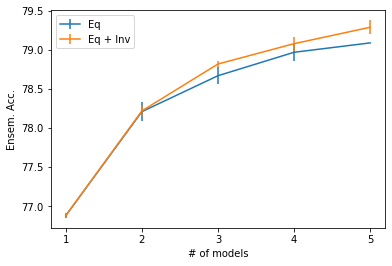

In [149]:
all_E = [76.88, 78.21, 78.67, 78.97, 79.09]
all_E_err = [0.03, 0.12, 0.11, 0.11, 0.0]

EI = [76.88, 78.22, 78.82, 79.08, 79.29]
EI_err = [0.03, 0.06, 0.04, 0.09, 0.09]

import matplotlib.pyplot as plt
plt.figure()
x = np.arange(1,6)
plt.errorbar(x,all_E, yerr=all_E_err,label='Eq')
plt.errorbar(x,EI, yerr=EI_err,label='Eq + Inv')
plt.xticks(x)
plt.xlabel("# of models")
plt.ylabel("Ensem. Acc.")
plt.legend()


In [110]:
# 3 models

num_comb = 5

ee_nll = []
ee_ece = []
ee_acc = []
for i in range(num_comb):
    [eq1, eq3] = np.random.choice(all_eq, 2, replace=False)
    [eq2] = np.random.choice(all_inv, 1, replace=False)
    ee_out = (eq1.softmax(-1) + eq2.softmax(-1) + eq3.softmax(-1))/3
    nll, ece, acc, _ = get_new_metrics([ee_out],[same_tar],[f'EE_comb{i}'], printing=False, input_softmax=True)    
    ee_nll.append(nll)
    ee_ece.append(ece)  
    ee_acc.append(acc)
print("EEI")
print(f"NLL: {np.mean(ee_nll):.4f} +/- {np.std(ee_nll):.4f}")
print(f"ECE: {np.mean(ee_ece):.4f} +/- {np.std(ee_ece):.4f}")
print(f"Acc: {np.mean(ee_acc):.4f} +/- {np.std(ee_acc):.4f}")

ee_nll = []
ee_ece = []
ee_acc = []
for i in range(num_comb):
    [eq1] = np.random.choice(all_eq, 1, replace=False)
    [eq2, eq3] = np.random.choice(all_inv, 2, replace=False)
    ee_out = (eq1.softmax(-1) + eq2.softmax(-1) + eq3.softmax(-1))/3
    nll, ece, acc, _ = get_new_metrics([ee_out],[same_tar],[f'EE_comb{i}'], printing=False, input_softmax=True)    
    ee_nll.append(nll)
    ee_ece.append(ece)  
    ee_acc.append(acc)
print("EII")
print(f"NLL: {np.mean(ee_nll):.4f} +/- {np.std(ee_nll):.4f}")
print(f"ECE: {np.mean(ee_ece):.4f} +/- {np.std(ee_ece):.4f}")
print(f"Acc: {np.mean(ee_acc):.4f} +/- {np.std(ee_acc):.4f}")

ee_nll = []
ee_ece = []
ee_acc = []
for i in range(num_comb):
    [eq1] = np.random.choice(all_eq, 1, replace=False)
    [eq2] = np.random.choice(all_inv, 1, replace=False)
    [eq3] = np.random.choice(all_base, 1, replace=False)
    
    ee_out = (eq1.softmax(-1) + eq2.softmax(-1) + eq3.softmax(-1))/3
    nll, ece, acc, _ = get_new_metrics([ee_out],[same_tar],[f'EE_comb{i}'], printing=False, input_softmax=True)    
    ee_nll.append(nll)
    ee_ece.append(ece)  
    ee_acc.append(acc)
print("EBI")
print(f"NLL: {np.mean(ee_nll):.4f} +/- {np.std(ee_nll):.4f}")
print(f"ECE: {np.mean(ee_ece):.4f} +/- {np.std(ee_ece):.4f}")
print(f"Acc: {np.mean(ee_acc):.4f} +/- {np.std(ee_acc):.4f}")

EEI
NLL: 0.8208 +/- 0.0029
ECE: 0.0223 +/- 0.0012
Acc: 0.7879 +/- 0.0010
EII
NLL: 0.8287 +/- 0.0033
ECE: 0.0202 +/- 0.0012
Acc: 0.7857 +/- 0.0012
EBI
NLL: 0.8199 +/- 0.0012
ECE: 0.0203 +/- 0.0008
Acc: 0.7879 +/- 0.0001


In [28]:
print("Three models ensembles (excluding all R seeds)")
eee_out = (eq24_out.softmax(-1) + eq69_out.softmax(-1) + eq42_out.softmax(-1))/3
bbb_out = (base31_out.softmax(-1) + base69_out.softmax(-1) + base24_out.softmax(-1))/3
iii_out = (inv31_out.softmax(-1) + inv69_out.softmax(-1) + inv_out.softmax(-1))/3
bie_out = (base31_out.softmax(-1) + inv_out.softmax(-1) + eq42_out.softmax(-1))/3

outs = [eee_out, bbb_out, iii_out, bie_out]
names = ['EEE', 'BBB', 'III','BIE']
tars = [same_tar, same_tar, same_tar, same_tar]
get_metrics_softmax(outs,tars,names)

Three models ensembles (excluding all R seeds)
EEE
NLL: 0.8169083595275879
ECE: 0.0158611989844963 0.015861209481954575
Acc: 0.7866799831390381
BBB
NLL: 0.830054759979248
ECE: 0.016954529612995678 0.016954533755779266
Acc: 0.7847999930381775
III
NLL: 0.8553289771080017
ECE: 0.01828231919476761 0.018282335251569748
Acc: 0.7801600098609924
BIE
NLL: 0.8212129473686218
ECE: 0.021877830814775068 0.021877823397517204
Acc: 0.7878599762916565


(0.8212129473686218, 0.021877823397517204, 0.7878599762916565)

In [26]:
num_comb = 3
all_eq_exR = [eq24_out, eq69_out, eq42_out, eq31_out]
all_base_exR = [base31_out, base24_out, base69_out]
all_inv_exR = [inv_out, inv31_out, inv24_out, inv69_out]
eee_nll = []
eee_ece = []
eee_acc = []
for i in range(num_comb):
    [eq1, eq2, eq3] = np.random.choice(all_eq_exR, 3, replace=False)
    eee_out = (eq1.softmax(-1) + eq2.softmax(-1) + eq3.softmax(-1))/3
    nll, ece, acc = get_metrics_softmax([eee_out],[same_tar],[f'EEE_comb{i}'])    
    eee_nll.append(nll)
    eee_ece.append(ece)  
    eee_acc.append(acc)   

bei_nll = []
bei_ece = []
bei_acc = []
for i in range(num_comb):
    [eq1] = np.random.choice(all_eq_exR, 1)
    [base1] = np.random.choice(all_base_exR, 1)
    [inv1] = np.random.choice(all_inv_exR, 1)
    bei_out = (eq1.softmax(-1) + base1.softmax(-1) + inv1.softmax(-1))/3
    nll, ece, acc = get_metrics_softmax([bei_out],[same_tar],[f'BEI_comb{i}'])    
    bei_nll.append(nll)
    bei_ece.append(ece)  
    bei_acc.append(acc) 

print(f"\nEEE Acc: {np.mean(eee_acc)} +/- {np.std(eee_acc)}")
print(f"EEE ECE: {np.mean(eee_ece)} +/- {np.std(eee_ece)}")
print(f"EEE NLL: {np.mean(eee_nll)} +/- {np.std(eee_nll)}")

print(f"\nBEI Acc: {np.mean(bei_acc)} +/- {np.std(bei_acc)}")
print(f"BEI ECE: {np.mean(bei_ece)} +/- {np.std(bei_ece)}")
print(f"BEI NLL: {np.mean(bei_nll)} +/- {np.std(bei_nll)}")


EEE_comb0
NLL: 0.8179500102996826
ECE: 0.017891318057477436 0.017891312018036842
Acc: 0.7876999974250793
EEE_comb1
NLL: 0.8179499506950378
ECE: 0.01789131802232935 0.017891310155391693
Acc: 0.7876999974250793
EEE_comb2
NLL: 0.8169081807136536
ECE: 0.015861198693104095 0.015861209481954575
Acc: 0.7866799831390381
BEI_comb0
NLL: 0.8216220140457153
ECE: 0.019913184124548008 0.019913190975785255
Acc: 0.7864800095558167
BEI_comb1
NLL: 0.8218128085136414
ECE: 0.019601914916858098 0.019601896405220032
Acc: 0.7866199612617493
BEI_comb2
NLL: 0.8229109644889832
ECE: 0.02157415859740229 0.02157415822148323
Acc: 0.7876399755477905

EEE Acc: 0.7873599926630656 +/- 0.0004808393457112864
EEE ECE: 0.01721461055179437 +/- 0.0009569990741491496
EEE NLL: 0.8176027139027914 +/- 0.0004911091284012794

BEI Acc: 0.7869133154551188 +/- 0.0005169930932547092
BEI ECE: 0.020363081867496174 +/- 0.0008657388092667003
BEI NLL: 0.8221152623494467 +/- 0.0005680123551444188


In [67]:
print("Four models ensembles (excluding all R seeds)")
eeee_out = (eq69_out.softmax(-1) + eq42_out.softmax(-1) + eq31_out.softmax(-1)+ eq24_out.softmax(-1))/4
bbee_out = (base69_out.softmax(-1) + base31_out.softmax(-1) + eq69_out.softmax(-1)+ eq42_out.softmax(-1))/4
biee_out = (base69_out.softmax(-1) + inv_out.softmax(-1) + eq69_out.softmax(-1)+ eq42_out.softmax(-1))/4

outs = [eeee_out, bbee_out, biee_out]
names = ['EEEE', 'BBEE', 'BIEE']
tars = [same_tar, same_tar, same_tar]
get_metrics_softmax(outs,tars,names)

Four models ensembles (excluding all R seeds)
EEEE
NLL: 0.8055247664451599
ECE: 0.02062973244084043 0.020629720762372017
Acc: 0.7910000085830688
BBEE
NLL: 0.8093110918998718
ECE: 0.020431804699562506 0.020431827753782272
Acc: 0.7896199822425842
BIEE
NLL: 0.8087023496627808
ECE: 0.02284597995162008 0.022845963016152382
Acc: 0.7899999618530273


In [48]:
print("5 models ensembles")
eeee_out = (eqR_out.softmax(-1) + eq69_out.softmax(-1) + eq42_out.softmax(-1) + eq31_out.softmax(-1)+ eq24_out.softmax(-1))/5
bbiee_out = (baseR_out.softmax(-1) + base31_out.softmax(-1) + inv_out.softmax(-1) + eq69_out.softmax(-1)+ eqR_out.softmax(-1))/5
bbbee_out = (baseR_out.softmax(-1) + base31_out.softmax(-1) + base69_out.softmax(-1) + eqR_out.softmax(-1) + eq69_out.softmax(-1))/5
bbeee_out = (baseR_out.softmax(-1) + base31_out.softmax(-1) + eqR_out.softmax(-1) + eq69_out.softmax(-1)+ eq42_out.softmax(-1))/5


['eee_out']


In [12]:
base100 = load_1_model("ft_base_e100_split1_cos_lr0.01_bs256")
eq100 = load_1_model("ft_eq_e100_split1_cos_lr0.01_bs256")
inv100 = load_1_model("ft_inv_e100_split1_cos_lr0.01_bs256")
base100_out, base100_tar = rollout_loader(base100, test_loader2)
eq100_out, eq100_tar = rollout_loader(eq100, test_loader2)
inv100_out, inv100_tar = rollout_loader(inv100, test_loader2)



loaded ft_base_e100_split1_cos_lr0.01_bs256
loaded ft_eq_e100_split1_cos_lr0.01_bs256
loaded ft_inv_e100_split1_cos_lr0.01_bs256


NameError: name 'get_metrics_softmax' is not defined

In [19]:
bei_out = (base100_out.softmax(-1) + eq100_out.softmax(-1) + inv100_out.softmax(-1))/3
assert (torch.equal(base100_tar, eq100_tar))
assert (torch.equal(base100_tar, inv100_tar))

get_metrics_softmax([base100_out.softmax(-1),eq100_out.softmax(-1),inv100_out.softmax(-1),bei_out],[eq100_tar,eq100_tar,eq100_tar,eq100_tar],['base','eq','inv','bei'])

base
NLL: 1.1335747241973877
ECE: 0.0813031126824394 0.08130313456058502
Acc: 0.7318199872970581
eq
NLL: 1.0972621440887451
ECE: 0.0758462802705169 0.07584623992443085
Acc: 0.7390599846839905
inv
NLL: 1.1724555492401123
ECE: 0.08375257655128837 0.08375254273414612
Acc: 0.7281799912452698
bei
NLL: 0.9417604804039001
ECE: 0.017339948233682657 0.017339937388896942
Acc: 0.766539990901947


(0.9417604804039001, 0.017339937388896942, 0.766539990901947)

In [28]:
base100_ts = load_1_ts_model("./checkpoints/ts_base_ft0.01_split1/checkpoint.pth", full_path=True)
eq100_ts = load_1_ts_model("./checkpoints/ts_eq_ft0.01_split1/checkpoint.pth", full_path=True)
inv100_ts = load_1_ts_model("./checkpoints/ts_inv_ft0.01_split1/checkpoint.pth", full_path=True)

base100_ts_out, base100_ts_tar = rollout_loader(base100_ts, test_loader2)
eq100_ts_out, eq100_ts_tar = rollout_loader(eq100_ts, test_loader2)
inv100_ts_out, inv100_ts_tar = rollout_loader(inv100_ts, test_loader2)


loaded ./checkpoints/ts_base_ft0.01_split1/checkpoint.pth
loaded ./checkpoints/ts_eq_ft0.01_split1/checkpoint.pth
loaded ./checkpoints/ts_inv_ft0.01_split1/checkpoint.pth


In [31]:
base100_ts_out_s = (base100_ts_out / base100_ts.temp.item()).softmax(-1)
eq100_ts_out_s = (eq100_ts_out / eq100_ts.temp.item()).softmax(-1)
inv100_ts_out_s = (inv100_ts_out / inv100_ts.temp.item()).softmax(-1)

bei_out_ts = (base100_ts_out_s + eq100_ts_out_s + inv100_ts_out_s)/3

get_metrics_softmax([base100_ts_out_s,eq100_ts_out_s,inv100_ts_out_s,bei_out_ts],[base100_ts_tar,base100_ts_tar,base100_ts_tar,base100_ts_tar],['base_ts','eq_ts','inv_ts','bei_ts'])

base_ts
NLL: 1.0563137531280518
ECE: 0.017097061355728665 0.01709705963730812
Acc: 0.7318199872970581
eq_ts
NLL: 1.0281479358673096
ECE: 0.020003060735017078 0.020003043115139008
Acc: 0.7390599846839905
inv_ts
NLL: 1.0874992609024048
ECE: 0.021374179718978686 0.021374162286520004
Acc: 0.7281799912452698
bei_ts
NLL: 0.9396365880966187
ECE: 0.06822165556107648 0.06822166591882706
Acc: 0.7676999568939209


(0.9396365880966187, 0.06822166591882706, 0.7676999568939209)

In [43]:
import scipy as sp
all100 = torch.stack([base100_out,eq100_out,inv100_out])
preds, _, _, ub = ensem_pred(all100,mode='hard_vote',target=eq100_tar)
all100_ts = torch.stack([(base100_ts_out / base100_ts.temp.item()),(eq100_ts_out / eq100_ts.temp.item()),(inv100_ts_out / inv100_ts.temp.item())])
preds_ts, _, _, ub_ts = ensem_pred(all100_ts,mode='hard_vote',target=eq100_tar)

tied fraction: 6e-05
conf: tensor([[0.2179, 0.5062, 0.6643,  ..., 0.9480, 0.2598, 0.6143],
        [0.6633, 0.8523, 0.7591,  ..., 0.4296, 0.5351, 0.5446],
        [0.6853, 0.7718, 0.6159,  ..., 0.7646, 0.4688, 0.4074]],
       device='cuda:0')
pred: tensor([[  1,   2,   3,  ..., 112, 998, 905],
        [396,   3, 394,  ..., 126, 452, 999],
        [396,   3, 394,  ..., 998, 419, 700]], device='cuda:0')
target: tensor([  1,   2,   3,  ..., 998, 998, 999], device='cuda:0')
batch_acc: 0.7615799903869629
Acc upper bound: tensor(0.8291, device='cuda:0')
tied fraction: 6e-05
conf: tensor([[0.1213, 0.4568, 0.5656,  ..., 0.7868, 0.1287, 0.4492],
        [0.4211, 0.7652, 0.5960,  ..., 0.2670, 0.3724, 0.3638],
        [0.4131, 0.6358, 0.5075,  ..., 0.5446, 0.2754, 0.3012]],
       device='cuda:0')
pred: tensor([[  1,   2,   3,  ..., 112, 998, 905],
        [396,   3, 394,  ..., 126, 452, 999],
        [396,   3, 394,  ..., 998, 419, 700]], device='cuda:0')
target: tensor([  1,   2,   3,  ..., 99

tensor(649, device='cuda:0')

In [36]:
def ensem_pred(outputs, mode='DE', num_ensem=3, target=None):
    if mode == 'DE':
        output = outputs.softmax(dim=-1).mean(dim=0)
        _, ensem_preds = output.max(1)
        batch_acc = (ensem_preds.long() == target).sum()/ len(target)
        # print("batch_acc:", batch_acc.item())
        conf, preds = outputs.max(dim=-1) # each has dim (M,B)
        pred_exist = (preds == target).sum(dim=0).bool()
        acc_ub = 1 - (~pred_exist).sum()/len(pred_exist)

        return ensem_preds, target, output, acc_ub * 100, pred_exist

    else:
        outputs = outputs.softmax(dim=-1)
        conf, preds = outputs.max(dim=-1) # each has dim (M,B)
        pred_exist = (preds == target).sum(dim=0).bool()
        acc_ub = 1 - (~pred_exist).sum()/len(pred_exist)

        if mode == 'most_conf':
            _, chosen_mem = conf.max(dim=0)
            chosen_mem = chosen_mem.unsqueeze(0)
            ensem_preds = torch.gather(preds,0,chosen_mem).squeeze(0)
            new_target = target
        if mode == 'hard_vote':
            predmode, count = sp.stats.mode(preds.cpu())
            # print("all preds:", preds)
            tie = (count < num_ensem - 1)
            ensem_preds = torch.Tensor(predmode[~tie]).to(outputs.device) # these are predictions without tie
            new_target = target[~tie]
            new_conf = conf.T[~tie].T
            new_preds = preds.T[~tie].T
            if num_ensem != 3:
                raise NotImplementedError("need to check tie condition")

            if tie.sum() > 0:
                tied_conf = conf.T[tie].T
                tied_preds = preds.T[tie].T
                # For samples under tie, choose the most confident model
                _, chosen_mem = tied_conf.max(dim=0)
                chosen_mem = chosen_mem.unsqueeze(0)
                tpreds = torch.gather(tied_preds,0,chosen_mem).squeeze(0) # these are predictions with tie
                ensem_preds = torch.cat([ensem_preds, tpreds],dim=0)
                new_target = torch.cat([new_target,target[tie]])
                new_conf = torch.cat([new_conf, tied_conf],dim=1)
                new_preds = torch.cat([new_preds, tied_preds],dim=1)

                print(f"tied fraction: {len(tied_preds)/len(ensem_preds)}")
            batch_acc = (ensem_preds.long() == new_target).sum()/ len(target)
            wrong_samples = (new_target != ensem_preds.long())
            wrong_conf = new_conf.T[wrong_samples].T
            wrong_preds = new_preds.T[wrong_samples].T
            wrong_target = new_target[wrong_samples]
            # print("target:", wrong_target)
            # print("pred matrix:", wrong_preds)
            pred_exist = (wrong_preds == wrong_target).sum(dim=0).bool()
            if len(pred_exist) > 0:
                print("conf:", wrong_conf.T[pred_exist].T)
                print("pred:", wrong_preds.T[pred_exist].T)
                print("target:", wrong_target[pred_exist])


            # print("conf matrix:", wrong_conf)

            print("batch_acc:", batch_acc.item())
            print("Acc upper bound:", acc_ub)

            assert(ensem_preds.shape[0] == outputs.shape[1])

        elif 'soft_vote' in mode: # each member's vote is weighted by its confidence
            print("Mode:",mode)
            if num_ensem != 3:
                raise NotImplementedError("need to check tie condition")
            # Can think of a faster way for this later
            # weighting only matters to switch decision when predictions are not tied (if 1 member conf > sum of 2 members)
            predmode, count = sp.stats.mode(preds.cpu())
            tie3 = (count == num_ensem) # if all members agree, prediction is straightforward
            ensem_preds = torch.Tensor(predmode[tie3]).to(outputs.device) # these are predictions without tie
            new_target = target[tie3]
            tie2 = (count == num_ensem - 1)
            if tie2.sum() > 0:
                newpred = preds.T[tie2].T
                newconf =conf.T[tie2].T
                pmode = torch.Tensor(predmode[tie2]).long().unsqueeze(0).to(outputs.device)
                conf_minority = (newconf * (newpred != pmode)).sum(dim=0)
                if mode == 'soft_vote_max':
                    conf_majority, _ = (newconf * (newpred == pmode)).max(dim=0)
                elif mode == 'soft_vote_sum':
                    conf_majority = (newconf * (newpred == pmode)).sum(dim=0)
                else:
                    raise "specify soft_vote_max or soft_vote_sum"
                ind_to_switch = conf_minority > conf_majority
                ensem_pred1 = newpred[(newpred != pmode)][ind_to_switch]
                ensem_pred2 = pmode.squeeze(0)[~ind_to_switch]
                ensem_preds = torch.cat([ensem_preds, ensem_pred1, ensem_pred2])
                new_target = torch.cat([new_target, target[tie2][ind_to_switch], target[tie2][~ind_to_switch]])
                print(f"switch fraction {len(ensem_pred1)/ (len(ensem_pred1)+len(ensem_pred2))}")

            tie = (count == 1)

            if tie.sum() > 0:
                tied_conf = conf.T[tie].T
                tied_preds = preds.T[tie].T
                # For samples under tie, choose the most confident model
                _, chosen_mem = tied_conf.max(dim=0)
                chosen_mem = chosen_mem.unsqueeze(0)
                tied_preds = torch.gather(tied_preds,0,chosen_mem).squeeze(0) # these are predictions with tie
                ensem_preds = torch.cat([ensem_preds, tied_preds],dim=0)
                new_target = torch.cat([new_target, target[tie]])
                print(f"tied fraction: {len(tied_preds)/len(ensem_preds)}")
            assert(ensem_preds.shape[0] == outputs.shape[1])
        return ensem_preds.long(), new_target, None, acc_ub * 100



In [21]:
sd = torch.load("./checkpoints/ts_base_ft0.01_split1/checkpoint.pth", map_location="cpu")

In [23]:
sd['model'].keys()

odict_keys(['temp', 'members.0.conv1.weight', 'members.0.bn1.weight', 'members.0.bn1.bias', 'members.0.bn1.running_mean', 'members.0.bn1.running_var', 'members.0.bn1.num_batches_tracked', 'members.0.layer1.0.conv1.weight', 'members.0.layer1.0.bn1.weight', 'members.0.layer1.0.bn1.bias', 'members.0.layer1.0.bn1.running_mean', 'members.0.layer1.0.bn1.running_var', 'members.0.layer1.0.bn1.num_batches_tracked', 'members.0.layer1.0.conv2.weight', 'members.0.layer1.0.bn2.weight', 'members.0.layer1.0.bn2.bias', 'members.0.layer1.0.bn2.running_mean', 'members.0.layer1.0.bn2.running_var', 'members.0.layer1.0.bn2.num_batches_tracked', 'members.0.layer1.0.conv3.weight', 'members.0.layer1.0.bn3.weight', 'members.0.layer1.0.bn3.bias', 'members.0.layer1.0.bn3.running_mean', 'members.0.layer1.0.bn3.running_var', 'members.0.layer1.0.bn3.num_batches_tracked', 'members.0.layer1.0.downsample.0.weight', 'members.0.layer1.0.downsample.1.weight', 'members.0.layer1.0.downsample.1.bias', 'members.0.layer1.0.do

In [19]:
from sklearn.metrics import brier_score_loss
y_true = all_targets.cpu().numpy()
probs = all_outputs.softmax(-1).cpu().numpy()

In [26]:
def brier_score(labels, softmaxes, name=None):
    '''The [Brier score][1] is a loss function for probabilistic predictions over a
  number of discrete outcomes.  For a probability vector `p` and a realized
  outcome `k` the Brier score is `sum_i p[i]*p[i] - 2*p[k]`. '''
#     labels = tf.convert_to_tensor(labels)
#     logits = tf.convert_to_tensor(logits)
#     probabilities = tf.math.softmax(logits, axis=1)

    num_classes = softmaxes.shape[-1]
    plabel = softmaxes * torch.nn.functional.one_hot(labels, num_classes)
    plabel = plabel.sum(-1)
    brier = (softmaxes ** 2).sum(-1) - 2. * plabel
    return brier

In [30]:
(brier_score(all_targets,all_outputs.softmax(-1))).mean()

tensor(-0.6700, device='cuda:0')

In [22]:
np.array([probs[i, idx] for i, idx in enumerate(y_true)]).shape

(50000,)

In [20]:
y_prob_true = np.array([probs[i, idx] for i, idx in enumerate(y_true)])  # Probability of positive class
brier = brier_score_loss(y_true=y_true, y_prob=y_prob_true)  # Brier Score (MSE)


ValueError: Only binary classification is supported. The type of the target is multiclass.

In [ ]:
ece_ensem, ece1, ece2, ece3 = 0., 0., 0., 0.
nll_ensem, nll1, nll2, nll3 = 0., 0., 0., 0.


targets = []
for it, (img, target) in enumerate(test_loader2):
    target = target.cuda(non_blocking=True)
    img = img.cuda(non_blocking=True)
    with torch.no_grad():
        output1 = model1(img)
        output2 = model2(img)
        output3 = model3(img)
        preds = torch.stack([output1,output2,output3])      
        naive_ensem = preds.softmax(dim=-1).mean(dim=0)
        ece_1 = ece_criterion(output1.softmax(-1), target)
        ece_2 = ece_criterion(output2.softmax(-1), target)
        ece_3 = ece_criterion(output3.softmax(-1), target)
        ece_e = ece_criterion(naive_ensem, target)  
        ece1 += ece_1
        ece2 += ece_2 
        ece3 += ece_3      
        ece_ensem += ece_e
#         print(ece_1, ece_2, ece_3)
#         nll1 += nll_criterion(output1.softmax(-1), target) 
#         nll2 += nll_criterion(output2.softmax(-1), target)  
#         nll3 += nll_criterion(output3.softmax(-1), target)      
#         nll_ensem += nll_criterion(naive_ensem, target) 

print(ece1/len(test_loader2), ece2/len(test_loader2),ece3/len(test_loader2))
print(ece_ensem/len(test_loader2))